# Quality control and annotation of sequence data 

## Introduction

A major challenge of biomedical research is the quality control (QC) of sequence data. False positive variant calls can hinder the ability to detect true disease associations or introduce spurious associations, therefore the need of a rigorous QC. This excercise focuses on QC after variant calling stage and requires a project variant calling format file (pVCF) as input. In our pipelines we have define default theresholds for genotype and variant-level hard filtering based on the UK Biobank (UKB) recommendations and a thorough review of the literature [[cf. Carson et al. BMC Bioinformatics (2014)](https://doi.org/10.1186/1471-2105-15-125),[cf. Lek et al. Nature (2016)](https://doi.org/10.1038/nature19057),[cf. Szustakowski et al. Nature Genetics (2021)](https://doi.org/10.1038/s41588-021-00885-0)]. 

Genotypes are set to missing if they have a Genotype Depth (DP)<8 for Single Nucleotide Variants (SNVs) and DP<10 for indels and a Genotype Quality (GQ)<20. Variant sites are excluded if none of the heterozygous samples have an Allelic Balance (AB)>= 0.15 for SNVs and AB>=0.20 for indels. Additionally, variants are removed if they are missing > 10%. For each variant, tests for deviation of Hardy Weinberg equilibrium (HWE) can be performed. These tests should only be performed in unrelated individuals from the same ancestry group.  If a case-control sample is undergoing QC, then usually tests of HWE are performed in the control group. Various p-values threshold have been used which is partially dependent on the sample size, e.g. 5 x 10-8, 5x10-12. 

Our pipeline uses bcftools to handle the left-normalization of indels, the formatting of multiallellic sites, annotate known/novel variants based on dbSNP, perfom genotype and variant level filtering based on genotype calling qualities and output summary statitics (TS/TV ratio) before and after QC to assess its effectiveness. The output of this mini-protocol is a quality controlled `vcg.gz` file for downstream analysis.

## Data

The following section describes the download of the publicly available sequencing data from 1000 Genomes and the creation of a minimal working example (MWE) that contains data from 489 `CEU` individuals. 

Please note that this is an example exercise and that for real data analysis much bigger sample sizes containing all the autosomes are needed. 

The analyses applied to these data will be:

1. Sequence data quality control: VCF_QC.ipynb
2. Annotation of variants: annovar.ipynb or vep.ipynb

### A. Generation of minimal working example (MWE)

The data was downloaded from the [1000G website](http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/). Only chromosome 21 will be used for the MWE to ensure that the exercise can be finished in a reasonable amount of time. After downloading the data we will subset the VCF file to contain only the `EUR` samples. To generate the MWE we use `bcftools` software.

In [1]:
# Load bcftools in our cluster and go to specific folder containing the downloaded file
module load BCFTOOLS/1.18
cd ~/MWE/mwe_regenie_statgen/public_data

#### Subset the EUR individuals excluding FIN
Only 534 Europeans individuals from CEU, TSI, GBR and IBS populations (note that we exclude FIN), list available [online](https://www.internationalgenome.org/api/beta/sample/_search/igsr_samples.tsv)
        - This file is generated from `20201028_CCDG_14151_B01_GRM_WGS_2020-08-05_chr21.recalibrated_variants.vcf.gz` (downloaded from [here](http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/20201028_3202_raw_GT_with_annot/)) using the following command:

In [119]:
bcftools view -Oz --no-version --samples-file ~/MWE/mwe_regenie_statgen/public_data/CEU_TSI_GBR_IBS.txt \
-o ~/MWE/mwe_regenie_statgen/public_data/EUR_except_FIN.vcf.gz \
~/MWE/mwe_regenie_statgen/public_data/20201028_CCDG_14151_B01_GRM_WGS_2020-08-05_chr21.recalibrated_variants.vcf.gz

(pisces-rabbit) 


In [7]:
# Generate the index file tbi format
bcftools index -t EUR_except_FIN.vcf.gz

### B. Generate summary statistics of the vcf file before running the VCF_QC pipeline

In [3]:
# You can generate a simple statistics of the file by running the code
bcftools stats EUR_except_FIN.vcf.gz > EUR_except_FIN.stats

No we can take a look at the beggining of that file and see how many samples, variants (SPNs, indels, multiallelic sites) are included in this vcf file

In [6]:
cat EUR_except_FIN.stats | grep  "^SN"

SN	0	number of samples:	534
SN	0	number of records:	1869057
SN	0	number of no-ALTs:	0
SN	0	number of SNPs:	1684570
SN	0	number of MNPs:	0
SN	0	number of indels:	212459
SN	0	number of others:	0
SN	0	number of multiallelic sites:	185506
SN	0	number of multiallelic SNP sites:	42304


Another metric for quality control is the TS/TV ratio or the transition to transversion ratio. This ratio varies if the sequence data comes from genomes or exomes

In [9]:
cat EUR_except_FIN.stats | grep  "^TSTV"

TSTV	0	1110789	622175	1.79	1071189	574876	1.86


# Step 1. Run the quality control (QC) on the VCF file. 

The idea of doing quality control is to remove sites with low quality so that we can avoid analyzing false positive variants.
Generally speaking the QC happens at different levels.
1. **Genotype QC:** genotypes that have read depth (DP) lower than 7 for SNPs and below 10 for indels and have genotype quality (GQ) below 20 are set to missing. Additionally, allelic balance (AB) is also used to do QC at the genotype level. 
AB refers to the proportion of reads covering a variant's location that provide support for that particular variant. For example, if there are 100 reads covering a variant's location, 25 of them support the variant and 75 do not, then the variant will have an AB=0.25 (25/100). 
2. **Variant QC:** variants with more than 10% missing genotypes should be removed. In this step many researchers choose to be more stringent removing those with more than 5% missing genotypes or some decide to allow for higher missingess rate (20%). In this step it is also recommended to remove monomorphic variants or those with allele count (AC) equal to zero in the sample being analyzed. 
3. **Sample QC:** in this step samples with a lot of missing genotypes, which indicates problems in the particular sequencing of that sample, should be removed. 


The goal of this section is to provide a final `vcf.gz` quality controlled file to be used in downstream analysis. 
The QC includes:
1. Handling left-alignment and normalization of indels (`bcftools norm`).
2. Check if REF alleles match the reference (`bcftools norm`).
3. Handling formatting of multi-allelic sites. In this case one multi-allelic site will be splitted into multiple rows (`bcftools norm`).
4. Genotype and variant level filtering based on genotype calling qualities (`bcftools filter`).
5. Known and novel variant annotation (`bcftools annotate`).
6. Summary statistics before and after QC. Particularly the TS/TV ratio, to assess the effectiveness of the QC (`bcftools stats`).


### A note on TS/TV ratio

`bcftools stats` command provides useful statistics to look at such as for example, the number of samples in the vcf file, the number of SNPs, indels, multiallelic sites, the transitions to transversion (TS/TV) ratio, the allele frequency distribution using the non-reference allele, the substitutions types, and the genotype depth (DP) distribution. 

1. Sample level TS/TV ratio: bcftools looks at each variant site to determine if a TS or TV has ocurred, counts the number of each occurrence and takes the ratio.

2. Individual level TS/TV ratio: bcftools determines for each heterozygous genotype if a TS or TV has ocurred. The number of TS and TV are counted and the ratio is obtained.

3. Sample level TS/TV ratio: snpsift takes the average of the individual TS/TV ratio

Therefore the TS/TV ratio obtained from bcftools will not necessarily equal the tS/TV ratio calculated from snpsift

It should be noted that for the sample level TS/TV bcftools simply counts the TS and TV event for observed SNPs in the data. Other tools, such as `snpsift`, implements variant level TS/TV by counting TS and TV events in sample genotypes and compute the ratio after summing up TS and TV across all samples. See [here](https://github.com/samtools/bcftools/issues/1526) some discussions on this issue.

### Input files

1. The target `vcf.gz` file
    - If its chromosome name does not have the `chr` prefix and you need it to match with reference `fasta` file, please run `rename_chrs` workflow to add `chr`.
    - The vcf.gz file needs to be compressed by bgzip, instead of simple gzip
    - It should have a index file accompanying it. The index file can be generated by tabix
    - It must be a valid vcf.gz file that can pass bcftools sanity check: i.e. all tags are defined properly
    - It must contains following fields:
        1. ##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Approximate read depth (reads with MQ=255 or with bad mates are filtered)">
        2. ##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
        3. ##FORMAT=<ID=AB,Number=1,Type=Float,Description="Allele balance for each het genotype">
 
2. dbSNP database in `VCF` format

3. A reference sequence `fasta` file

###  Run the VCF QC using `bcftools` pipeline

In [1]:
module load Singularity/3.11.4

In [13]:
sos run ~/project/xqtl-pipeline/pipeline/VCF_QC.ipynb qc    \
    --genoFile ~/MWE/mwe_regenie_statgen/public_data/EUR_except_FIN.vcf.gz  \
    --dbsnp-variants /mnt/vast/hpc/csg/snuc_pseudo_bulk/data/reference_data/00-All.add_chr.variants.gz \
    --reference-genome /mnt/vast/hpc/csg/snuc_pseudo_bulk/data/reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta \
    --cwd ~/MWE/mwe_regenie_statgen/bcftools/qc \
    --DP_snp 7 \
    --DP_indel 10 \
    --GQ 20 \
    --AB_snp 0.15 \
    --AB_indel 0.20 \
    --geno_filter 0.1 \
    --hwe_filter 1e-08 \
    --container oras://ghcr.io/cumc/bioinfo_apptainer:latest

INFO: Running variant preprocessing: Handel multi-allelic sites, left normalization of indels and add variant ID
HINT: Pulling singularity image oras://ghcr.io/cumc/bioinfo_apptainer:latest to ~/.sos/singularity/library/ghcr.io-cumc-bioinfo_apptainer-latest.sif
HINT: Singularity image oras://ghcr.io/cumc/bioinfo_apptainer:latest is now up to date
INFO: variant preprocessing is completed.
INFO: variant preprocessing output:   /home/dmc2245/MWE/mwe_regenie_statgen/bcftools/qc/EUR_except_FIN.leftnorm.vcf.gz
INFO: Running variant level QC: genotype QC
INFO: variant level QC is completed.
INFO: variant level QC output:   /home/dmc2245/MWE/mwe_regenie_statgen/bcftools/qc/EUR_except_FIN.leftnorm.bcftools_qc.vcf.gz
INFO: Running genotype data summary statistics: 
INFO: qc_3 (index=1) is completed.
INFO: qc_3 (index=0) is completed.
INFO: genotype data summary statistics output:   /home/dmc2245/MWE/mwe_regenie_statgen/bcftools/qc/EUR_except_FIN.leftnorm.novel_variant_sumstats /home/dmc2245/MWE/

### Convert VCF  to plink format

This step is done so that we have the correct format to perfom the following analyses: KING and ANNOVAR

In [15]:
sos run ~/project/xqtl-pipeline/code/data_preprocessing/genotype/genotype_formatting.ipynb vcf_to_plink \
    --genoFile ~/MWE/mwe_regenie_statgen/bcftools/qc/EUR_except_FIN.leftnorm.bcftools_qc.vcf.gz \
    --cwd ~/MWE/mwe_regenie_statgen/plink \
    --container oras://ghcr.io/cumc/bioinfo_apptainer:latest 

INFO: Running vcf_to_plink: 
INFO: vcf_to_plink is completed.
INFO: vcf_to_plink output:   /home/dmc2245/MWE/mwe_regenie_statgen/plink/EUR_except_FIN.leftnorm.bcftools_qc.bed
INFO: Workflow vcf_to_plink (ID=w3802b20fda3937d5) is executed successfully with 1 completed step.


# Step 2. Kinship calculation using KING 

Kinship coefficients are used to estimate genetic similarity between pairs of individuals [Goudet, Kay & Weir 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6220858/)

Some kinship coefficients for the most common relationships are given below:

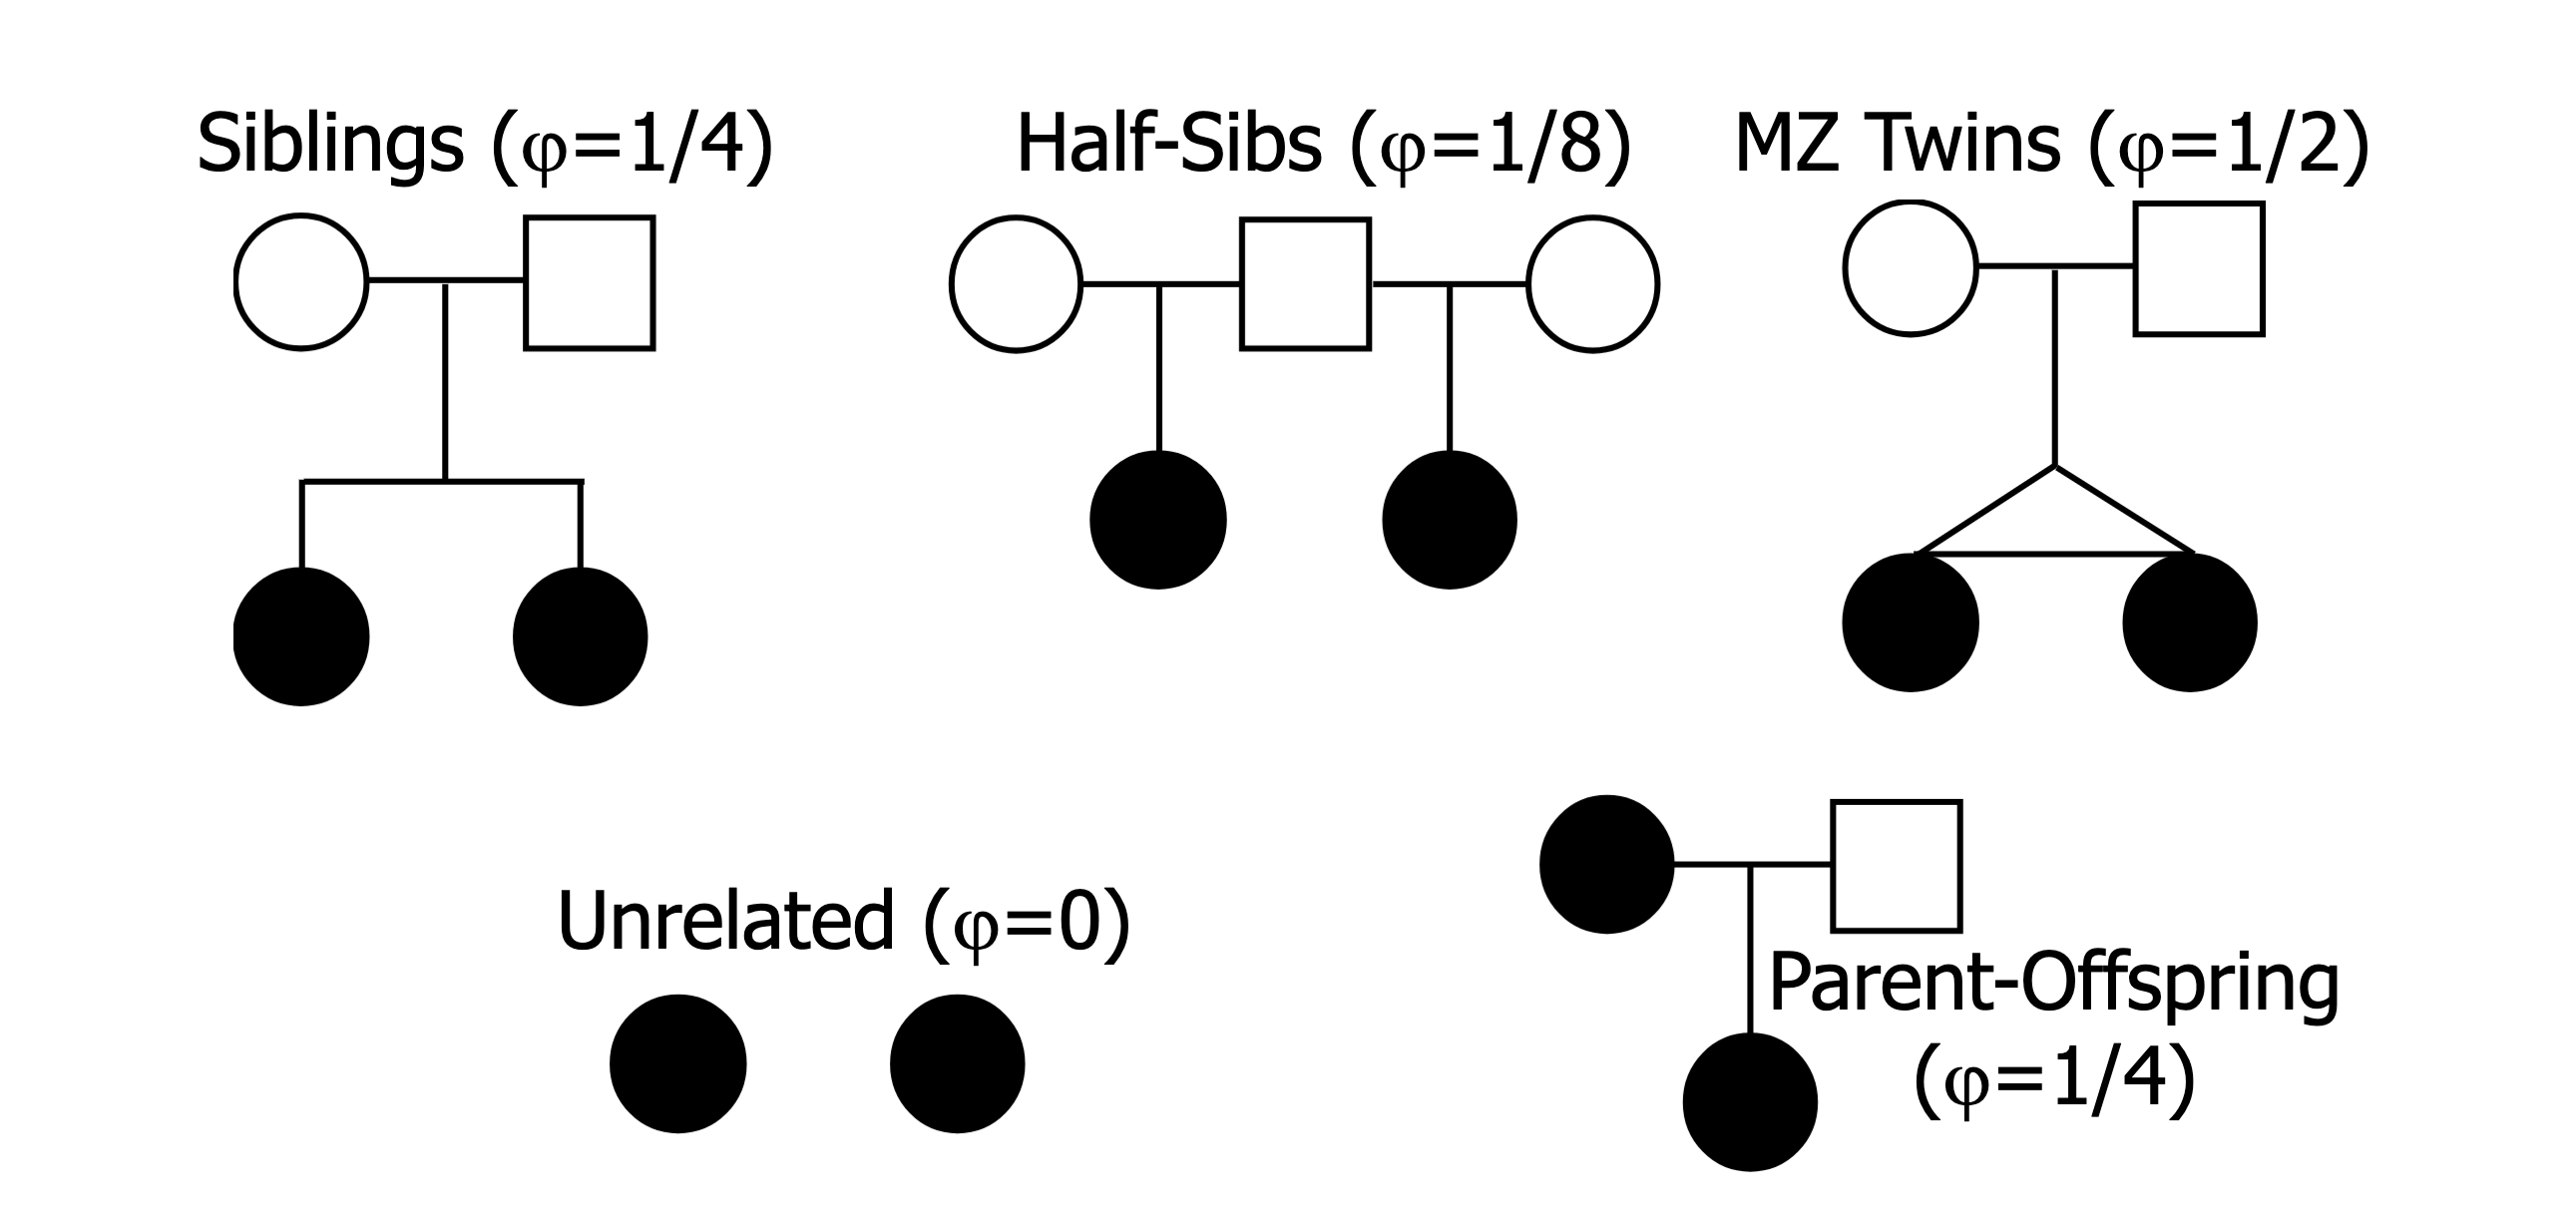

KING robust kinship estimator [Manichaikul et al 2010](https://pubmed.ncbi.nlm.nih.gov/20926424/) as implemented in PLINK 2 is used. Please note that the estimates are scaled such that duplicated samples have a kinship of 0.5, not 1. First-degree relationships (parent-child, full siblings) correspond to ~0.25, second-degree relations to ~0.125 and third-degree relations to 0.0625. 

This step is also important to decide which methods you should use when doing GWAS, if generalize linear models (GLM) or generalized linear mixed models (GLMM) depending of whether you have related individuals in your sample or not. 

Generally speaking,the sex chromosomes are used to check for sex inconsistencies and remove those samples in which the biogolical sex does not match the genetic sex. In this example, as we are only using the chromosome 21, so we will skip this part, but please keep in mind that this is an important QC step. 


In [17]:
sos run ~/project/xqtl-pipeline/code/data_preprocessing/genotype/GWAS_QC.ipynb king \
    --cwd /home/dmc2245/MWE/mwe_regenie_statgen/kinship \
    --genoFile /home/dmc2245/MWE/mwe_regenie_statgen/plink/EUR_except_FIN.leftnorm.bcftools_qc.bed \
    --name vcf_qc \
    --kinship 0.0625 \ 
    --container oras://ghcr.io/cumc/bioinfo_apptainer:latest \
    --no-maximize-unrelated \
    --mem 40G

INFO: Running king_1: Inference of relationships in the sample to identify closely related individuals
INFO: king_1 is completed.
INFO: king_1 output:   /home/dmc2245/MWE/mwe_regenie_statgen/kinship/EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.kin0
INFO: Running king_2: Select a list of unrelated individual with an attempt to maximize the unrelated individuals selected from the data
INFO: king_2 is completed.
INFO: king_2 output:   /home/dmc2245/MWE/mwe_regenie_statgen/kinship/EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.related_id
INFO: Running king_3: Split genotype data into related and unrelated samples, if related individuals are detected
INFO: king_3 is completed.
INFO: king_3 output:   /home/dmc2245/MWE/mwe_regenie_statgen/kinship/EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.unrelated.bed /home/dmc2245/MWE/mwe_regenie_statgen/kinship/EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.related.bed
INFO: Workflow king (ID=wf497e1d5517be287) is executed successfully with 3 completed steps.


At the end of this step you'll have many different outputs. 
1. The kinship table `EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.kin0`
2. A list of related individuals depending on the threshold that you provided. In our case we have set a threshold for third-degree relatedness of 0.0625 `EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.related_id`
3. Two sets of binary plink files {`.bed`, `.bim`, `.fam`}, on for the related and another one for the unrelated individuals 

### Questions

1. Are there any duplicated samples in this dataset?

In [19]:
cat ~/MWE/mwe_regenie_statgen/kinship/EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.kin0 | awk '{if ($8>=0.5) print}'

#FID1	IID1	FID2	IID2	NSNP	HETHET	IBS0	KINSHIP


**Answer 1**

There are not duplicated samples. 

2. Can you look at examples of first, second and third-degree relatives  present in the dataset?

**Answer 2**

Tip: remember that first-degree relatives will have a kinship close to 0.25, second-degree ~0.125 and third-degree ~0.0625

In [21]:
cat ~/MWE/mwe_regenie_statgen/kinship/EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.kin0 | awk '{if ($8>=0.25) print}' | head

#FID1	IID1	FID2	IID2	NSNP	HETHET	IBS0	KINSHIP
0	HG01502	0	HG01501	148190	0.129462	8.09771e-05	0.259812
0	HG01505	0	HG01503	147877	0.130906	0.000135248	0.257039
0	HG01505	0	HG01504	147864	0.136605	0.000108208	0.268499
0	HG01508	0	HG01507	148177	0.126383	0.000344183	0.262841
0	HG01511	0	HG01509	148000	0.125932	0.000195946	0.261724
0	HG01511	0	HG01510	147990	0.127441	0.000128387	0.26512
0	HG01517	0	HG01516	148247	0.127139	0.000141655	0.250892
0	HG01520	0	HG01518	147907	0.14044	0.000500314	0.267912
0	HG01520	0	HG01519	147967	0.128022	0.000189231	0.254314


In [24]:
cat ~/MWE/mwe_regenie_statgen/kinship/EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.kin0 | awk '{if ($8>=0.125 && $8 <=0.177) print}' | head

0	NA12801	0	NA06997	148235	0.109819	0.017081	0.161222
0	NA12813	0	NA06997	148525	0.11182	0.0211884	0.1463


In [25]:
cat ~/MWE/mwe_regenie_statgen/kinship/EUR_except_FIN.leftnorm.bcftools_qc.vcf_qc.kin0 | awk '{if ($8>=0.0625 && $8 <=0.1) print}' | head

0	HG00109	0	HG00096	148207	0.104314	0.0334937	0.0723772
0	HG00120	0	HG00108	148158	0.102742	0.030643	0.0756258
0	HG00120	0	HG00111	148094	0.0909625	0.0266993	0.067749
0	HG00121	0	HG00111	147955	0.0909871	0.0294684	0.0661175
0	HG00122	0	HG00113	148029	0.10042	0.0326693	0.0639786
0	HG00131	0	HG00122	148114	0.102549	0.0337173	0.0656286
0	HG00159	0	HG00122	148234	0.104288	0.0316999	0.0747412
0	HG00234	0	HG00122	148217	0.104495	0.0338828	0.0710836
0	HG00234	0	HG00131	148101	0.102626	0.034652	0.063338
0	HG00234	0	HG00159	148238	0.103354	0.0312605	0.0757392


# Step 3. Variant annotation using ANNOVAR

Variant annotation is a very important process after quality control of vcf files for downstream analysis as it provides more information on the functionality of the variants and help prioritize variants or genes that are directly involved in 

There is a lot of information that can be annotated to a variant. For example, in Annovar when you use gene-based annotation, the first column (`func.`) annotates the variant to a region if it falls in an exonic, splicing, ncRNA, intronic or intergenic location (for more information look [here](https://annovar.openbioinformatics.org/en/latest/user-guide/gene/). If the variant is exonic/intronic/ncRNA then the second column (`gene.`) gives the gene name (if multiple genes are hit then they are comma separated), if not it will output the two neighboring genes and the distance to those genes. The third column (`ExonicFunc.`) will show whether a variant that is exonic can can be annotated. Filter based annotation identifies variants that appear in specific databases such as those based on allele frequencies like 1000 Genomes, Genome Aggregation Database (gnomAD) and Exome Aggregation Consortium (ExAC) or annotates based functional prediction using tools like SIFT, Polyphen, FATHMM or CADD and GERP++ for whole genome data predictions. 

In [2]:
sos run ~/project/bioworkflows/variant-annotation/annovar.ipynb annovar \
    --cwd /home/dmc2245/MWE/mwe_regenie_statgen/annovar \
    --bim_name /home/dmc2245/MWE/mwe_regenie_statgen/plink/EUR_except_FIN.leftnorm.bcftools_qc.bim \
    --humandb /mnt/vast/hpc/csg/isabelle/REF/humandb \
    --xref_path /mnt/vast/hpc/csg/isabelle/REF/humandb \
    --job_size 1 \
    --build 'hg38' \
    --name_prefix chr21_mwe \
    --container_annovar ~/containers/gatk4-annovar.sif

INFO: Running annovar_1: Create annovar input file
INFO: annovar_1 is completed.
INFO: annovar_1 output:   /home/dmc2245/MWE/mwe_regenie_statgen/annovar/EUR_except_FIN.leftnorm.bcftools_qc.hg38.avinput
INFO: Running annovar_2: Annotate variants file using ANNOVAR
INFO: annovar_2 is completed.
INFO: annovar_2 output:   /home/dmc2245/MWE/mwe_regenie_statgen/annovar/EUR_except_FIN.leftnorm.bcftools_qc.hg38.hg38_multianno.csv
INFO: Workflow annovar (ID=w125331767d75a15d) is executed successfully with 2 completed steps.
